In [1]:
from keras import backend as K
from keras import layers
from keras.layers import Conv2D, BatchNormalization, Activation, Conv2DTranspose, Input, MaxPooling2D, Concatenate, Add
from keras.layers import Cropping2D
from keras.models import Model
from keras.models import load_model

from keras.preprocessing.image import ImageDataGenerator
from keras.engine.topology import Layer
from keras.applications import VGG19
from keras.optimizers import Adam
from keras.utils.data_utils import get_file
from keras.regularizers import Regularizer
from keras.engine import InputSpec
import tensorflow as tf
import h5py
import pandas as pd
import numpy as np
import os
import time
import cv2
import matplotlib.pyplot as plt
import sys
import imageio


def construct_model(img_height=220,
                    img_width=176,
                    TV_weight=50,
                    alpha=4,
                    vgg19_weights_file="models/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"):
    

    
    
    # CREATE CUSTOM LAYERS FOR USE IN MODEL:
    
    # Create Normalization layer
    class Normalize(Layer):
        def __init__(self, **kwargs):
            super(Normalize, self).__init__(**kwargs)

        def call(self, x, mask=None):
            return x / 255.
        
    # Create Denormalization layer
    class Denormalize(Layer):
        def __init__(self, **kwargs):
            super(Denormalize, self).__init__(**kwargs)

        def call(self, x, mask=None):
            return x * 255
    

    # Allows network to learn identify function, (NOT SURE IF THIS IS NECESSARY)
    def residual_block(ip, id):
        init = ip

        x = ReflectionPadding2D()(ip)
        x = Conv2D(128, (3, 3), activation='linear', padding='valid',
                          name='res_conv_' + str(id) + '_1')(x)
        x = BatchNormalization(axis=1, name="res_batchnorm_" + str(id) + "_1")(x)
        x = Activation('relu', name="res_activation_" + str(id) + "_1")(x)

        x = ReflectionPadding2D()(x)
        x = Conv2D(128, (3, 3), activation='linear', padding='valid',
                          name='res_conv_' + str(id) + '_2')(x)
        x = BatchNormalization(axis=1, name="res_batchnorm_" + str(id) + "_2")(x)

        m = Add()([x, init])
        #m = Activation('relu', name="res_activation_" + str(id))(m)

        return m
        
        
        
    # create ReflectionPadding layer
    # https://github.com/misgod/fast-neural-style-keras/blob/master/layers.py
    class ReflectionPadding2D(Layer):
        def __init__(self, padding=(1, 1), dim_ordering='default', **kwargs):
            super(ReflectionPadding2D, self).__init__(**kwargs)

            if dim_ordering == 'default':
                dim_ordering = K.image_dim_ordering()

            self.padding = padding
            if isinstance(padding, dict):
                if set(padding.keys()) <= {'top_pad', 'bottom_pad', 'left_pad', 'right_pad'}:
                    self.top_pad = padding.get('top_pad', 0)
                    self.bottom_pad = padding.get('bottom_pad', 0)
                    self.left_pad = padding.get('left_pad', 0)
                    self.right_pad = padding.get('right_pad', 0)
                else:
                    raise ValueError('Unexpected key found in `padding` dictionary. '
                                     'Keys have to be in {"top_pad", "bottom_pad", '
                                     '"left_pad", "right_pad"}.'
                                     'Found: ' + str(padding.keys()))
            else:
                padding = tuple(padding)
                if len(padding) == 2:
                    self.top_pad = padding[0]
                    self.bottom_pad = padding[0]
                    self.left_pad = padding[1]
                    self.right_pad = padding[1]
                elif len(padding) == 4:
                    self.top_pad = padding[0]
                    self.bottom_pad = padding[1]
                    self.left_pad = padding[2]
                    self.right_pad = padding[3]
                else:
                    raise TypeError('`padding` should be tuple of int '
                                    'of length 2 or 4, or dict. '
                                    'Found: ' + str(padding))

            if dim_ordering not in {'tf'}:
                raise ValueError('dim_ordering must be in {tf}.')
            self.dim_ordering = dim_ordering
            self.input_spec = [InputSpec(ndim=4)] 


        def call(self, x, mask=None):
            top_pad=self.top_pad
            bottom_pad=self.bottom_pad
            left_pad=self.left_pad
            right_pad=self.right_pad        


            paddings = [[0,0],[left_pad,right_pad],[top_pad,bottom_pad],[0,0]]


            return tf.pad(x,paddings, mode='REFLECT', name=None)

        def compute_output_shape(self,input_shape):
            if self.dim_ordering == 'tf':
                rows = input_shape[1] + self.top_pad + self.bottom_pad if input_shape[1] is not None else None
                cols = input_shape[2] + self.left_pad + self.right_pad if input_shape[2] is not None else None

                return (input_shape[0],
                        rows,
                        cols,
                        input_shape[3])
            else:
                raise ValueError('Invalid dim_ordering:', self.dim_ordering)


        def get_config(self):
            config = {'padding': self.padding}
            base_config = super(ReflectionPadding2D, self).get_config()
            return dict(list(base_config.items()) + list(config.items()))     

        
        
    # Build mask generation net
    def generate_mask_net():
           
        # Build model architecture
        input_img = Input(shape=(img_height, img_width, 3))

        x = Normalize()(input_img)

        x = ReflectionPadding2D(padding=(4,4))(x)
        x = Conv2D(32, (9, 9), strides=(1,1), activation='linear', padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(64, (3, 3), strides=(2,2), activation='linear', padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(128, (3, 3), strides=(2,2), activation='linear', padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)


        r1 = residual_block(x, 1)
        r2 = residual_block(r1, 2)
        r3 = residual_block(r2, 3)
        r4 = residual_block(r3, 4)
        x = residual_block(r4, 5)


        x = Conv2DTranspose(64, (3, 3), strides=(2,2), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2DTranspose(32, (3, 3), strides=(2,2), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = ReflectionPadding2D((4, 4))(x)
        y = Conv2D(3, (9, 9), strides=(1,1), activation='tanh', padding='valid',
                            name='mask_output')(x)


        model_mask_net = Model(inputs=input_img, outputs=y)
        print("Mask model architecture is loaded")

        return model_mask_net
    
    
    
    
    # add vgg19 convolutional base to autoencoder
    def vgg_net(mask, orig_input):
        
        orig_input_norm = Normalize()(orig_input)
        masked_input = Add()([mask, orig_input_norm])
    
        
        # create new tensor of original and masked inputs
        input_tensor = Concatenate(axis=0)([masked_input, orig_input_norm]) 

        # Build out VGG19 Architecture
        x = Conv2D(64, (3, 3), activation='relu', name='block1_conv1', padding='same')(input_tensor)
        x = Conv2D(64, (3, 3), activation='relu', name='block1_conv2', padding='same')(x)
        x = MaxPooling2D((2, 2), strides=(2, 2))(x)

        x = Conv2D(128, (3, 3), activation='relu', name='block2_conv1', padding='same')(x)
        x = Conv2D(128, (3, 3), activation='relu', name='block2_conv2', padding='same')(x)
        x = MaxPooling2D((2, 2), strides=(2, 2))(x)

        x = Conv2D(256, (3, 3), activation='relu', name='block3_conv1', padding='same')(x)
        x = Conv2D(256, (3, 3), activation='relu', name='block3_conv2', padding='same')(x)
        x = Conv2D(256, (3, 3), activation='relu', name='block3_conv3', padding='same')(x)
        x = Conv2D(256, (3, 3), activation='relu', name='block3_conv4', padding='same')(x)
        x = MaxPooling2D((2, 2), strides=(2, 2))(x)

        x = Conv2D(512, (3, 3), activation='relu', name='block4_conv1', padding='same')(x)
        x = Conv2D(512, (3, 3), activation='relu', name='block4_conv2', padding='same')(x)
        x = Conv2D(512, (3, 3), activation='relu', name='block4_conv3', padding='same')(x)
        x = Conv2D(512, (3, 3), activation='relu', name='block4_conv4', padding='same')(x)
        x = MaxPooling2D((2, 2), strides=(2, 2))(x)

        x = Conv2D(512, (3, 3), activation='relu', name='block5_conv1', padding='same')(x)
        x = Conv2D(512, (3, 3), activation='relu', name='block5_conv2', padding='same')(x)
        x = Conv2D(512, (3, 3), activation='relu', name='block5_conv3', padding='same')(x)
        x = Conv2D(512, (3, 3), activation='relu', name='block5_conv4', padding='same')(x)
        z = MaxPooling2D((2, 2), strides=(2, 2))(x)   


        full_model = Model(inputs=orig_input, outputs=z)
        print("VGG Model has been loaded and appended to network")

        # Download and set weights
        f = h5py.File(vgg19_weights_file)
        layer_names = [name for name in f.attrs['layer_names']][1:] # chop off input layer

        for i, layer in enumerate(full_model.layers[-21:]):
            g = f[layer_names[i]]
            weights = [g[name] for name in g.attrs['weight_names']]
            layer.set_weights(weights)
        print("VGG19 Weights have been set successfully")






#         #Add losses as regulizers
#         add_interpolation_loss(full_model, orig_input_norm, alpha, w)
#         add_total_variation_loss(mask_net.layers[-1], weight=TV_weight)
        
#         # Freeze all VGG layers
#         for layer in full_model.layers[-21:]:
#             layer.trainable = False

        return full_model
    
    
    
    
#     def add_interpolation_loss(full_model, orig_input, alpha, w):

#         vgg_layers = dict([(layer.name, layer) for layer in full_model.layers[-21:]])
        
#         # output layers
#         content_layer = ["block3_conv1", "block4_conv1", "block5_conv1"]

#         layers = [vgg_layers[layer] for layer in content_layer]
#         interpolation_regularizer = FeatureInterpolationRegularizer()(layers, alpha, w)
        
#         # add_loss function to apply regularization loss to any layer
#         layers[2].add_loss(interpolation_regularizer)
        
        
        
#     # Loss function to be applied as a Regularizer
#     class FeatureInterpolationRegularizer(Regularizer):

#         def __init__(self):
#             super(FeatureInterpolationRegularizer, self).__init__()

#         def __call__(self, layer, a, w):
#             phi_x_r = [K.flatten(layer[i].output[0]) for i in range(3)]
#             phi_x_r = K.concatenate(phi_x_r)  # Image + mask feature

#             phi_x = [K.flatten(layer[i].output[1]) for i in range(3)]
#             phi_x = K.concatenate(phi_x) # Original image features

#             delta = phi_x_r - (phi_x + w * a)
#             loss = K.sum(K.square(delta))

#             return loss
        
    
    
#     def add_total_variation_loss(transform_output_layer,weight):
#         # Total Variation Regularization
#         layer = transform_output_layer  # Output layer
#         tv_regularizer = TVRegularizer(weight)(layer)
#         layer.add_loss(tv_regularizer)
    
    
#     class TVRegularizer(Regularizer):
#         """ Enforces smoothness in image output. """

#         def __init__(self, weight):
#             self.weight = weight
#             self.uses_learning_phase = False
#             super(TVRegularizer, self).__init__()

#         def __call__(self, x):
#             assert K.ndim(x.output) == 4
#             x_out = x.output 

#             shape = K.shape(x_out)
#             img_width, img_height,channel = (shape[1],shape[2], shape[3])
#             size = img_width * img_height * channel 
#             if K.image_dim_ordering() == 'th':
#                 a = K.square(x_out[:, :, :img_width - 1, :img_height - 1] - x_out[:, :, 1:, :img_height - 1])
#                 b = K.square(x_out[:, :, :img_width - 1, :img_height - 1] - x_out[:, :, :img_width - 1, 1:])
#             else:
#                 a = K.square(x_out[:, :img_width - 1, :img_height - 1, :] - x_out[:, 1:, :img_height - 1, :])
#                 b = K.square(x_out[:, :img_width - 1, :img_height - 1, :] - x_out[:, :img_width - 1, 1:, :])
#             loss = self.weight * K.sum(K.pow(a + b, 1.25)) 
#             return loss
    
    
    
    
        
    
    
    mask_net = generate_mask_net()
    model = vgg_net(mask_net.output,mask_net.input)
    
    return model, mask_net



    


model, mask_net = construct_model()

Using TensorFlow backend.


Mask model architecture is loaded
VGG Model has been loaded and appended to network
VGG19 Weights have been set successfully


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


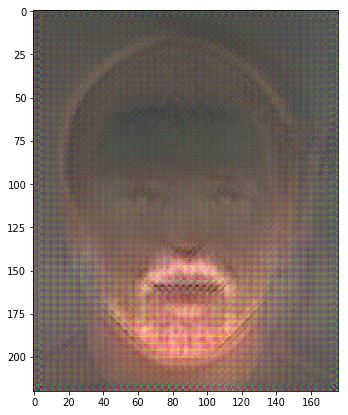

In [5]:
def import_image(image,
                 image_directory,
                 resize_dims=(176,220)):
    
    """
    load image, change from bgr to rgb, resize dimensions, normalize pixel values
    input: 
        image: a jpg image
        resize_dims: dimensions to resize (downsample) image to
    output: 
        image processed for neural net
    """
    
    image_bgr = cv2.imread(image_directory+image, cv2.IMREAD_COLOR)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_resize = cv2.resize(image_rgb, resize_dims)
    img = np.expand_dims(image_resize, 0)
    return img




def mask_predict(input_img, model):

    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
    predict_func = K.function([model.layers[0].input],
                               [outputs_dict['mask_output']])

    return predict_func([input_img])


def save_image(model_weights,
               image_name,
               image_directory,
               destination_filepath,
               model):
    
    img = import_image(image_name,
                       image_directory)
    
    model.load_weights(filepath=model_weights)
    test_mask = mask_predict(img, model=model)[0][0]

    plt.figure(figsize=(7,7))
    plt.imshow(test_mask-test_mask.min())
    np.save(destination_filepath+image_name[:-4]+"_mask",
            test_mask)


# 168670
# 163410
# 165130
save_image(model_weights='models/fast_brd2cln_grp.h5',
           image_name='170605.jpg',
           image_directory="data/val/yes_attribute/",
           destination_filepath='data/numpy_masks/',
           model=model)
    